# Exploratory data analysis of findings

This notebook explores the implications of these findings in cancerous tissue specimens.

## 0. Initializations

In [146]:
## 0. Initializations
# -- imports --
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from collections import defaultdict

from signals_in_the_noise.preprocessing.gse161529 import GSE161529
from signals_in_the_noise.utilities.storage import get_resources_path
from signals_in_the_noise.utilities.visualization import get_figure_axes

In [147]:
# -- datasets --
gse = GSE161529()

2025-08-13 20:34:53,886 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909253_N-PM0092-Total.h5ad as AnnData object.
2025-08-13 20:34:53,948 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909254_N-PM0019-Total.h5ad as AnnData object.
2025-08-13 20:34:54,033 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909255_N-N280-Epi.h5ad as AnnData object.
2025-08-13 20:34:54,070 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909256_N-PM0095-Epi.h5ad as AnnData object.
2025-08-13 20:34:54,169 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909257_N-PM0095-Total.h5ad 

In [148]:
def apply_findings(adata):
    """
    This method modifies the data object IN PLACE
    :param adata: 
    :return: 
    """
    mito_high = adata.obs['pct_counts_mt'].describe()['75%']
    mito_mod = adata.obs['pct_counts_mt'].describe()['50%']
    mito_lo = adata.obs['pct_counts_mt'].describe()['25%']
    rna_high = adata.obs['log1p_total_counts'].describe()['75%']
    rna_mod = adata.obs['log1p_total_counts'].describe()['50%']
    rna_lo = adata.obs['log1p_total_counts'].describe()['25%']
    gene_high = adata.obs['log1p_n_genes_by_counts'].describe()['75%']
    gene_mod = adata.obs['log1p_n_genes_by_counts'].describe()['50%']
    gene_lo = adata.obs['log1p_n_genes_by_counts'].describe()['25%']
    
    mask_mito_high = adata.obs['pct_counts_mt'] >= mito_high
    mask_genes_high = adata.obs['log1p_n_genes_by_counts'] >= gene_high
    
    mask_mito_moderate = (adata.obs['pct_counts_mt'] > mito_lo) & (adata.obs['pct_counts_mt'] < mito_high)
    mask_rna_moderate = (adata.obs['log1p_total_counts'] > rna_lo) & (adata.obs['log1p_total_counts'] < rna_high)
    mask_genes_moderate = (adata.obs['log1p_n_genes_by_counts'] > gene_lo) & (adata.obs['log1p_n_genes_by_counts'] < gene_high)
    
    mask_mito_low = adata.obs['pct_counts_mt'] <= mito_lo
    mask_rna_low = adata.obs['log1p_total_counts'] <= rna_lo
    mask_genes_low = adata.obs['log1p_n_genes_by_counts'] <= gene_lo
    
    mask_damaged = mask_mito_high & mask_rna_low & mask_genes_low
    mask_dormant = mask_mito_low & mask_rna_low & mask_genes_moderate
    mask_multifunction = mask_mito_moderate & mask_rna_moderate & mask_genes_high
    
    adata.obs['damaged'] = mask_damaged.astype(bool)
    adata.obs['dormant'] = mask_dormant.astype(bool)
    adata.obs['multifunction'] = mask_multifunction.astype(bool)

## 1. Apply findings

Apply findings to tissue specimens that are classified as from "Total" cell population and explore.

In [149]:
# -- filter data for only total cell populations and apply findings --
filtered_data = defaultdict(list)
for adata in gse.objects.values():
    if adata.uns['cell_population'] != 'Total':
        continue
    apply_findings(adata)
    cancer_type = adata.uns['cancer_type']
    filtered_data[cancer_type].append(adata)

annotated_filtered_data = {}
for cancer_type, adatas in filtered_data.items():
    annotate = f"{cancer_type} ({len(adatas)} specimens)"
    annotated_filtered_data[annotate] = adatas

In [150]:
potential_signals_by_cancer_type = {}
for cancer_type, adatas in annotated_filtered_data.items():
    sum_damaged = 0
    sum_dormant = 0
    sum_multifunction = 0
    sum_noise = 0
    sum_total = 0
    for adata in adatas:
        sum_damaged += adata.obs['damaged'].sum()
        sum_dormant += adata.obs['dormant'].sum()
        sum_multifunction += adata.obs['multifunction'].sum()
        sum_noise += adata.obs['is_noise'].sum()
        sum_total += adata.shape[0]

    potential_signals_by_cancer_type[cancer_type] = (sum_damaged, sum_dormant, sum_multifunction, sum_noise, sum_total)

potential_signals_df = pd.DataFrame(potential_signals_by_cancer_type)
potential_signals_df.index = ['damaged', 'dormant', 'multifunction', 'noise', 'total']
potential_signals_df = potential_signals_df.T

In [151]:
# normalize counts to total noise (for biological signals) total count (for noise)
potential_signals_norm_df = potential_signals_df[['damaged', 'dormant', 'multifunction']].div(potential_signals_df['noise'], axis=0)
potential_signals_norm_df['noise'] = potential_signals_df['noise'].div(potential_signals_df['total'], axis=0)
potential_signals_norm_df = potential_signals_norm_df * 100

In [152]:
# prepare data for visualization - convert to long form
long_form_potential_signals_df = potential_signals_norm_df[['damaged', 'dormant', 'multifunction']].reset_index()
long_form_potential_signals_df.columns.values[0] = 'cancer type'
long_form_potential_signals_df = long_form_potential_signals_df.melt(
    id_vars='cancer type',
    var_name='potential signal',
    value_name='percentage of noise',
)

long_form_noise_df = potential_signals_norm_df['noise'].reset_index()
long_form_noise_df.columns.values[0] = 'cancer type'
long_form_noise_df = long_form_noise_df.melt(
    id_vars='cancer type',
    var_name='potential signal',
    value_name='percentage of noise',
)

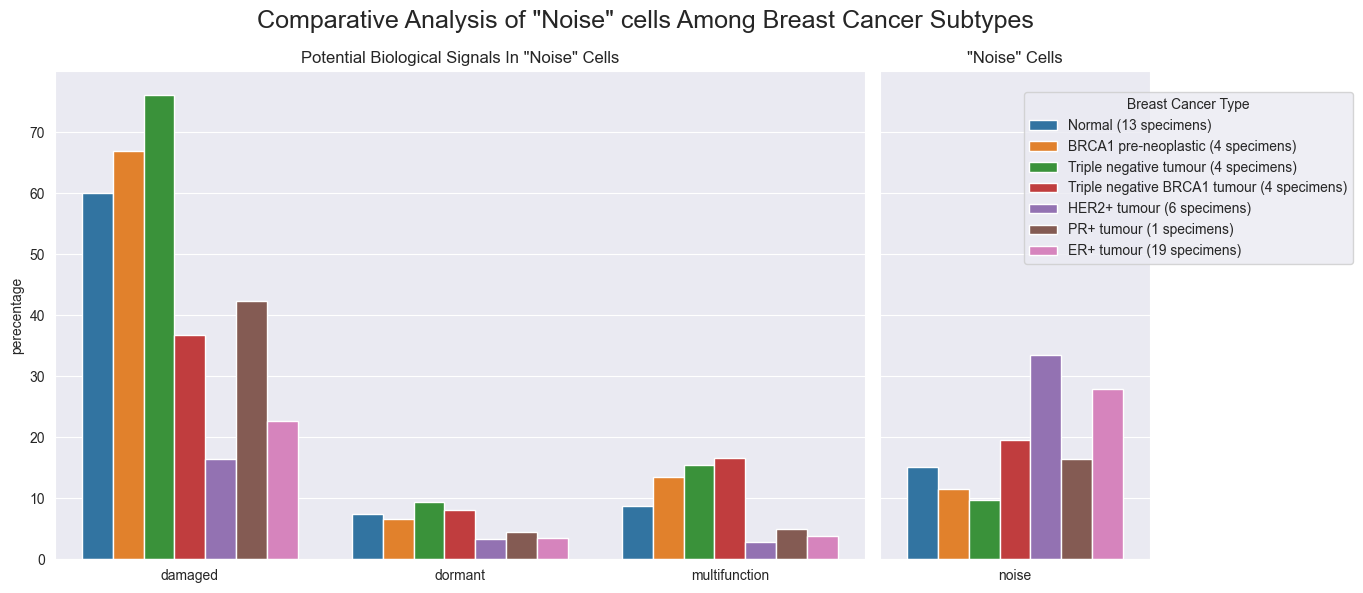

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6), gridspec_kw={'width_ratios': [3,1]}, sharey=True)
sns.barplot(data=long_form_potential_signals_df, x='potential signal', y='percentage of noise', hue='cancer type', ax=ax1)
ax1.set_title('Potential Biological Signals In "Noise" Cells')
ax1.set_xlabel('')
ax1.set_ylabel('perecentage')
ax1.get_legend().remove()

sns.barplot(data=long_form_noise_df, x='potential signal', y='percentage of noise', hue='cancer type', ax=ax2)
ax2.set_title('"Noise" Cells')
ax2.set_xlabel('')
ax2.set_ylabel('percentage')
ax2.get_legend().remove()

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Breast Cancer Type', loc='center right', bbox_to_anchor=(1.05, 0.70))
plt.suptitle('Comparative Analysis of "Noise" cells Among Breast Cancer Subtypes', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for legend
plt.show()